In [3]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy pandas matplotlib seaborn scipy sklearn tensorflow keras scikit-learn nltk jupyterlab notebook

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [5]:
pip list

Package                                  Version
---------------------------------------- ---------------
absl-py                                  2.2.2
aiohappyeyeballs                         2.6.1
aiohttp                                  3.11.18
aiosignal                                1.3.2
altair                                   5.5.0
annotated-types                          0.7.0
anyio                                    4.8.0
argon2-cffi                              23.1.0
argon2-cffi-bindings                     21.2.0
arrow                                    1.3.0
asgiref                                  3.8.1
asttokens                                3.0.0
astunparse                               1.6.3
async-lru                                2.0.4
attrs                                    25.2.0
azure-core                               1.33.0
babel                                    2.17.0
backoff                                  2.2.1
bcrypt                                   

In [6]:
!pip install opencv-python tqdm imutils



Defaulting to user installation because normal site-packages is not writeable


In [11]:
import numpy as np
import pandas as pd
import os 
import cv2 
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns

In [25]:
data_dir =  r"C:\Users\91940\Downloads\project git\fire_dataset\fire_dataset"

In [26]:

img_size = (128, 128)
batch_size = 32

import os, cv2, numpy as np
from tqdm import tqdm


In [ ]:
label_map = {"fire_images": 1, "non_fire_images": 0}

X, y = [], []

for cls_name, label in label_map.items():
    folder = os.path.join(data_dir, cls_name)
    
    if not os.path.exists(folder):
        print(f"Warning: Folder '{folder}' does not exist. Skipping.")
        continue
    
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))]
    for fname in tqdm(files, desc=f"Loading {cls_name}"):
        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        X.append(img)
        y.append(label)

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int64)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Counts of fire:", (y==1).sum(), "non_fire:", (y==0).sum())

Loading non_fire_images: 100%|██████████| 244/244 [00:13<00:00, 18.44it/s]


X shape: (999, 128, 128, 3)
y shape: (999,)
Counts -> fire: 755 non_fire: 244


In [28]:


# First split: train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: from temp → val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

def shape_counts(name, y_):
    return f"{name}: {y_.shape[0]}  (fire={int((y_==1).sum())}, no_fire={int((y_==0).sum())})"

print(shape_counts("train", y_train))
print(shape_counts("val",   y_val))
print(shape_counts("test",  y_test))

# Sanity: total should match 999
print("Total:", y_train.size + y_val.size + y_test.size)


train: 699  (fire=528, no_fire=171)
val: 150  (fire=114, no_fire=36)
test: 150  (fire=113, no_fire=37)
Total: 999


In [30]:


INPUT_SHAPE = (128, 128, 3)

# ----   Handle class imbalance with weights ----
pos = int((y_train == 1).sum())   # fire
neg = int((y_train == 0).sum())   # non-fire
total = len(y_train)
class_weight = {
    0: total / (2.0 * neg),
    1: total / (2.0 * pos)
}
print("Class weights:", class_weight)

# ----   Data augmentation ----
# Randomly flip, rotate, zoom images to help the model generalize better
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")

# ----  Define CNN model ----
def make_model():
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = data_aug(inputs)

    #  Convolutional layer:
    # Applies learnable filters that detect features like edges, flames, and textures.
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)

    #  Pooling layer:
    # Reduces spatial dimensions, keeping key information while lowering computation.
    x = layers.MaxPooling2D()(x)

    #  Another pair of Conv + Pool layers for deeper feature learning
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    #  Dropout:
    # Randomly deactivates some neurons to prevent overfitting.
    x = layers.Dropout(0.3)(x)

    #  Flatten:
    # Converts 3D feature maps into a 1D vector.
    x = layers.Flatten()(x)

    #  Dense layer:
    # Learns nonlinear combinations of features from previous layers.
    x = layers.Dense(128, activation="relu")(x)

    #  Dropout again for better generalization.
    x = layers.Dropout(0.3)(x)

    #  Output layer:
    # One neuron with sigmoid activation for binary classification (fire / no fire).
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    #  Compile:
    # Adam optimizer adjusts learning rate automatically for efficiency.
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

# ----   Create model ----
model = make_model()
model.summary()

# ----   Train the model ----
# Training for ~20 epochs is a good starting point.
# We monitor AUC (area under curve) to detect overfitting early.
es = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    mode="max",
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)


Class weights: {0: 2.043859649122807, 1: 0.6619318181818182}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.7911 - auc: 0.8711 - loss: 0.4340 - val_accuracy: 0.9400 - val_auc: 0.9912 - val_loss: 0.2037
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.8784 - auc: 0.9597 - loss: 0.2585 - val_accuracy: 0.9667 - val_auc: 0.9967 - val_loss: 0.1470
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9199 - auc: 0.9739 - loss: 0.2277 - val_accuracy: 0.9467 - val_auc: 0.9961 - val_loss: 0.1295
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.9227 - auc: 0.9741 - loss: 0.2131 - val_accuracy: 0.8933 - val_auc: 0.9921 - val_loss: 0.2024
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.9156 - auc: 0.9769 - loss: 0.2032 - val_accuracy: 0.9533 - val_auc: 0.9959 - val_loss: 0.0851


Test → acc: 0.940  auc: 0.987  loss: 0.167

Classification report:
              precision    recall  f1-score   support

    non_fire      0.967     0.784     0.866        37
        fire      0.933     0.991     0.961       113

    accuracy                          0.940       150
   macro avg      0.950     0.887     0.914       150
weighted avg      0.942     0.940     0.938       150



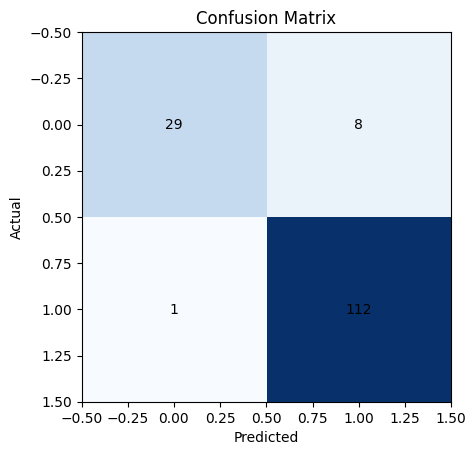

Test → acc: 0.940  auc: 0.987  loss: 0.167

Classification report:
              precision    recall  f1-score   support

    non_fire      0.967     0.784     0.866        37
        fire      0.933     0.991     0.961       113

    accuracy                          0.940       150
   macro avg      0.950     0.887     0.914       150
weighted avg      0.942     0.940     0.938       150



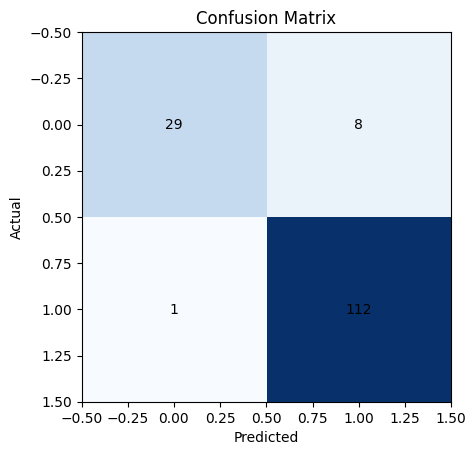

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# 1) Keras metrics on the held-out test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test → acc: {test_acc:.3f}  auc: {test_auc:.3f}  loss: {test_loss:.3f}")

# 2) Thresholded predictions @ 0.5
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["non_fire","fire"], digits=3))

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()


# 1) Keras metrics on the held-out test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test → acc: {test_acc:.3f}  auc: {test_auc:.3f}  loss: {test_loss:.3f}")

# 2) Thresholded predictions @ 0.5
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["non_fire","fire"], digits=3))

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()


In [33]:

from sklearn.metrics import precision_recall_fscore_support

best = None
targets = []
for t in np.linspace(0.3, 0.9, 13):  # try thresholds
    y_pred_t = (y_prob >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_t, labels=[0,1], zero_division=0)
    # metrics by class: index 0=non_fire, 1=fire
    macro_f1 = f1.mean()
    targets.append((t, p[0], r[0], f1[0], p[1], r[1], f1[1], macro_f1))
    if best is None or macro_f1 > best[-1]:
        best = (t, macro_f1)

print("Best threshold by macro-F1:", best)
print("t | non_fire(p,r,f1) | fire(p,r,f1) | macroF1")
for t, p0, r0, f10, p1, r1, f11, mf1 in targets:
    print(f"{t:0.2f} | {p0:0.3f},{r0:0.3f},{f10:0.3f} | {p1:0.3f},{r1:0.3f},{f11:0.3f} | {mf1:0.3f}")


Best threshold by macro-F1: (np.float64(0.6000000000000001), np.float64(0.9555555555555555))
t | non_fire(p,r,f1) | fire(p,r,f1) | macroF1
0.30 | 1.000,0.486,0.655 | 0.856,1.000,0.922 | 0.788
0.35 | 1.000,0.568,0.724 | 0.876,1.000,0.934 | 0.829
0.40 | 1.000,0.622,0.767 | 0.890,1.000,0.942 | 0.854
0.45 | 0.963,0.703,0.812 | 0.911,0.991,0.949 | 0.881
0.50 | 0.967,0.784,0.866 | 0.933,0.991,0.961 | 0.914
0.55 | 0.917,0.892,0.904 | 0.965,0.973,0.969 | 0.937
0.60 | 0.921,0.946,0.933 | 0.982,0.973,0.978 | 0.956
0.65 | 0.875,0.946,0.909 | 0.982,0.956,0.969 | 0.939
0.70 | 0.833,0.946,0.886 | 0.981,0.938,0.959 | 0.923
0.75 | 0.783,0.973,0.867 | 0.990,0.912,0.949 | 0.908
0.80 | 0.735,0.973,0.837 | 0.990,0.885,0.935 | 0.886
0.85 | 0.706,0.973,0.818 | 0.990,0.867,0.925 | 0.871
0.90 | 0.643,0.973,0.774 | 0.989,0.823,0.899 | 0.836


Accuracy: 0.940

Classification report (0=non_fire, 1=fire):
              precision    recall  f1-score   support

    non_fire      0.967     0.784     0.866        37
        fire      0.933     0.991     0.961       113

    accuracy                          0.940       150
   macro avg      0.950     0.887     0.914       150
weighted avg      0.942     0.940     0.938       150



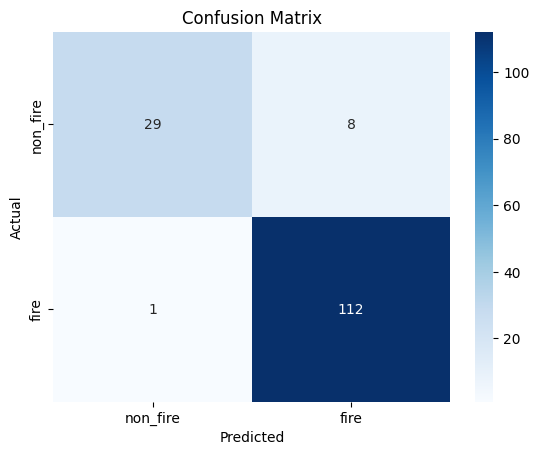

Accuracy: 0.940

Classification report (0=non_fire, 1=fire):
              precision    recall  f1-score   support

    non_fire      0.967     0.784     0.866        37
        fire      0.933     0.991     0.961       113

    accuracy                          0.940       150
   macro avg      0.950     0.887     0.914       150
weighted avg      0.942     0.940     0.938       150



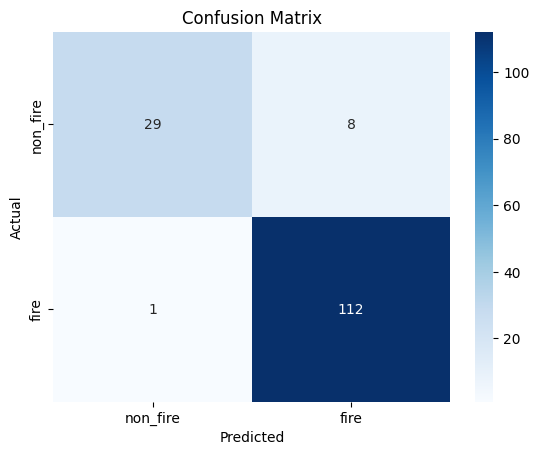

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 1) Predict (threshold 0.5)
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 2) Print metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}\n")

print("Classification report (0=non_fire, 1=fire):")
print(classification_report(y_test, y_pred, target_names=["non_fire","fire"], digits=3))

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non_fire","fire"],
            yticklabels=["non_fire","fire"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


# 1) Predict (threshold 0.5)
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 2) Print metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}\n")

print("Classification report (0=non_fire, 1=fire):")
print(classification_report(y_test, y_pred, target_names=["non_fire","fire"], digits=3))

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non_fire","fire"],
            yticklabels=["non_fire","fire"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


In [36]:
from tensorflow.keras import layers, Sequential

data_aug = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name="augment_stronger")


In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

base = keras.applications.MobileNetV2(
    input_shape=(128,128,3), include_top=False, weights="imagenet"
)
base.trainable = False  # freeze first stage

inputs = keras.Input((128,128,3))
x = data_aug(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
tl_model = keras.Model(inputs, outputs)

tl_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="binary_crossentropy",
                 metrics=["accuracy", keras.metrics.AUC(name="auc")])

tl_history = tl_model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=10, batch_size=32,
                          class_weight=class_weight, verbose=1)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.5207 - auc: 0.4950 - loss: 0.7369 - val_accuracy: 0.7400 - val_auc: 0.6177 - val_loss: 0.6619
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5036 - auc: 0.5167 - loss: 0.7222 - val_accuracy: 0.6933 - val_auc: 0.6378 - val_loss: 0.6764
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5536 - auc: 0.5259 - loss: 0.7144 - val_accuracy: 0.2400 - val_auc: 0.6728 - val_loss: 0.7476
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.4607 - auc: 0.5212 - loss: 0.7187 - val_accuracy: 0.7933 - val_auc: 0.6923 - val_loss: 0.6498
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4678 - auc: 0.4848 - loss: 0.7313 - val_accuracy: 0.7600 - val_auc: 0.7136 - val_loss: 0.6050
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5522 - auc: 0.5573 - loss: 0.7011 - val_accuracy: 0.7667 - val_auc: 0.7424 - val_los

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

base = keras.applications.MobileNetV2(
    input_shape=(128,128,3), include_top=False, weights="imagenet"
)
base.trainable = False  # freeze first stage

inputs = keras.Input((128,128,3))
x = data_aug(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
tl_model = keras.Model(inputs, outputs)

tl_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="binary_crossentropy",
                 metrics=["accuracy", keras.metrics.AUC(name="auc")])

tl_history = tl_model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=10, batch_size=32,
                          class_weight=class_weight, verbose=1)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.4721 - auc: 0.4619 - loss: 0.7518 - val_accuracy: 0.7600 - val_auc: 0.5347 - val_loss: 0.6477
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5165 - auc: 0.4886 - loss: 0.7374 - val_accuracy: 0.2667 - val_auc: 0.6256 - val_loss: 0.7014
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.4764 - auc: 0.5107 - loss: 0.7200 - val_accuracy: 0.7600 - val_auc: 0.6987 - val_loss: 0.6293
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4878 - auc: 0.5261 - loss: 0.7159 - val_accuracy: 0.7733 - val_auc: 0.7657 - val_loss: 0.6701
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.5379 - auc: 0.5201 - loss: 0.7183 - val_accuracy: 0.2400 - val_auc: 0.7862 - val_loss: 0.7351
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5236 - auc: 0.5453 - loss: 0.7053 - val_accuracy: 0.8267 - val_auc: 0.8085 - val_loss: 0.6743
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5

In [39]:
es = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                   patience=5, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                        patience=2, min_lr=1e-6)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=40, batch_size=32,
                    class_weight=class_weight,
                    callbacks=[es, rlr], verbose=1)


Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.9199 - auc: 0.9687 - loss: 0.2498 - val_accuracy: 0.8933 - val_auc: 0.9910 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.9256 - auc: 0.9767 - loss: 0.2040 - val_accuracy: 0.9467 - val_auc: 0.9971 - val_loss: 0.1139 - learning_rate: 0.0010
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.9242 - auc: 0.9817 - loss: 0.1844 - val_accuracy: 0.8467 - val_auc: 0.9917 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.9528 - auc: 0.9894 - loss: 0.1299 - val_accuracy: 0.9200 - val_auc: 0.9979 - val_loss: 0.1946 - learning_rate: 0.0010
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.9471 - auc: 0.9902 - loss: 0.1200 - val_accuracy: 0.9200 - val_auc: 0.9966 - val_loss: 0.2562 - learning_rate: 5.0000e-04
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.9657 - au

In [40]:
import tensorflow as tf
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        pt = tf.where(tf.equal(y_true,1), y_pred, 1-y_pred)
        w  = tf.where(tf.equal(y_true,1), alpha, 1-alpha)
        return -tf.reduce_mean(w * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=binary_focal_loss(gamma=2, alpha=0.25),
              metrics=["accuracy", keras.metrics.AUC(name="auc")])


In [44]:
import os
os.makedirs("models", exist_ok=True)

# New Keras format (recommended)
model.save("models/fire_cnn.keras")
print("Saved to models/fire_cnn.keras")

# (Alt) SavedModel format
# model.export("models/fire_cnn_savedmodel")


Saved to models/fire_cnn.keras


In [49]:
import cv2
import numpy as np
import tensorflow as tf
from collections import deque

# --- config ---
MODEL_PATH = "models/fire_cnn.keras"
CAM_INDEX  = 0                 # change to 0/2 if needed
BACKEND    = cv2.CAP_ANY     # good on Windows; try CAP_MSMF or CAP_ANY if issues
IMG_SIZE   = (128, 128)

THRESH     = 0.70              # probability threshold
SMOOTH_N   = 7                 # frames kept for voting
ALARM_NEED = 5                 # votes needed to show FIRE
MOTION_T   = 0.010             # ~1% moving pixels required

# --- load model ---
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("Model loaded.")

# --- open webcam ---
cap = cv2.VideoCapture(CAM_INDEX, BACKEND)
if not cap.isOpened():
    raise RuntimeError(f"Could not open webcam at index {CAM_INDEX} with backend {BACKEND}.")

prev_gray = None
votes = deque(maxlen=SMOOTH_N)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # ---------- motion (flicker) gate ----------
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    motion_ratio = 0.0
    if prev_gray is not None:
        diff = cv2.absdiff(gray, prev_gray)
        _, diff_bin = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        motion_ratio = (diff_bin > 0).mean()  # fraction of pixels that changed
    prev_gray = gray

    # ---------- model prediction ----------
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)
    x   = (img.astype(np.float32) / 255.0)[None, ...]
    prob = float(model.predict(x, verbose=0)[0][0])

    # require BOTH high prob and enough motion
    gated_fire = (prob >= THRESH) and (motion_ratio >= MOTION_T)

    votes.append(1 if gated_fire else 0)
    smooth_pred = 1 if sum(votes) >= ALARM_NEED else 0

    # ---------- overlay ----------
    label = ("FIRE " if smooth_pred else "NO FIRE ") + f"{prob:.2f}"
    color = (0, 0, 255) if smooth_pred else (0, 200, 0)
    cv2.putText(frame, label, (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
    cv2.rectangle(frame, (5, 5), (260, 50), color, 2)
    cv2.putText(frame, f"motion:{motion_ratio:.3f}", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    cv2.imshow("Fire Detector (q to quit)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model loaded.


In [46]:
import cv2
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    print("Camera not opened")
else:
    ret, frame = cap.read()
    print("Frame captured:", ret)
    if ret:
        cv2.imshow("Test", frame)
        cv2.waitKey(2000)
        cv2.destroyAllWindows()
cap.release()


Camera not opened
